K=1 -> Acurácia: 0.8767
K=3 -> Acurácia: 0.8794
K=5 -> Acurácia: 0.8772
K=7 -> Acurácia: 0.8794
K=9 -> Acurácia: 0.8825
K=11 -> Acurácia: 0.8854
K=13 -> Acurácia: 0.8873
K=15 -> Acurácia: 0.8844
K=17 -> Acurácia: 0.8854
K=19 -> Acurácia: 0.8844
K=21 -> Acurácia: 0.8841


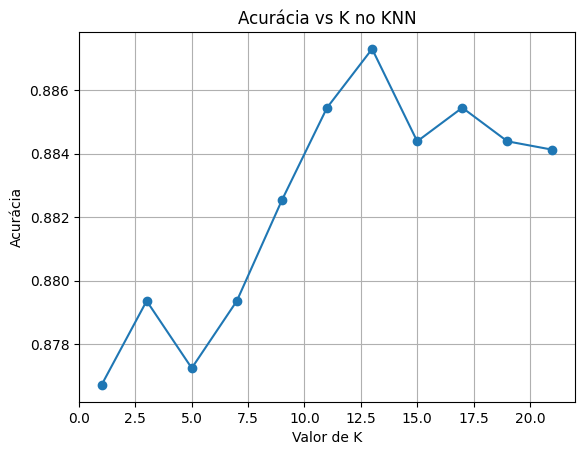

acurácia média validação cruzada (K=13): 0.8140
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1931
           1       0.85      0.93      0.89      1849

    accuracy                           0.89      3780
   macro avg       0.89      0.89      0.89      3780
weighted avg       0.89      0.89      0.89      3780



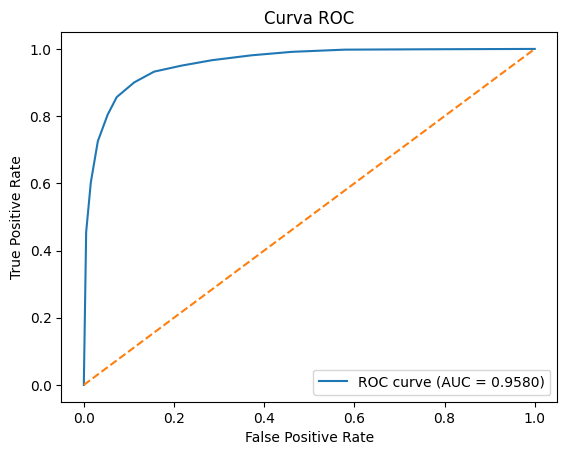

Sensibilidade: 0.9324
Especificidade: 0.8441


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

fake_df = pd.read_csv("Fake.csv", header=None)
true_df = pd.read_csv("True.csv", header=None)

# Adiciona coluna de rótulo
fake_df["label"] = 0
true_df["label"] = 1

# Cria coluna  de texto combinando colunas 0 e 1 (título + corpo)
fake_df["text"] = fake_df[0] + " " + fake_df[1]
true_df["text"] = true_df[0] + " " + true_df[1]

# Junta os dados
df = pd.concat([fake_df, true_df])

# Cria vetor de características usando TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.8, min_df=5, ngram_range=(1,2))
X = vectorizer.fit_transform(df["text"])
y = df["label"]

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Testa diferentes valores de K e salva acurácias
ks = list(range(1, 22, 2))
accuracies = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"K={k} -> Acurácia: {acc:.4f}")

# EXibe gráfico de acurácia vs K
plt.figure()
plt.plot(ks, accuracies, marker='o')
plt.xlabel("Valor de K")
plt.ylabel("Acurácia")
plt.title("Acurácia vs K no KNN")
plt.grid(True)
plt.show()

# Validação cruzada com melhor K
best_k = ks[accuracies.index(max(accuracies))]
knn = KNeighborsClassifier(n_neighbors=best_k)
scores = cross_val_score(knn, X, y, cv=5, scoring="accuracy")
print(f"acurácia média validação cruzada (K={best_k}): {scores.mean():.4f}")

# Treinamento e avaliação do modelo KNN com melhor K
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Curva ROC
y_prob = knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Matriz de confusão, sensibilidade e especificidade
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
sensibilidade = tp / (tp + fn)
especificidade = tn / (tn + fp)
print(f"Sensibilidade: {sensibilidade:.4f}")
print(f"Especificidade: {especificidade:.4f}")

# Interpretação dos resultados
#
# desempenho do knn
# acurácia ≈ 0.89 e auc = 0.958 → desempenho global bom
# sensibilidade = 0.93 > especificidade = 0.84
# modelo acerta mais quando a notícia é verdadeira
# classe 0 (fake) sofre mais → recall 0.84 vs 0.93 da classe 1 (true)

# leitura
# modelo mais cuidadoso com verdadeiras, menos eficiente em detectar fakes
# valor de k influencia bastante → k baixo instável, melhora até ~13, onde estabiliza
# erros ligados à semelhança entre textos reais e falsos + limitação do knn em alta dimensão

# conclusão
# classificador consistente e com bom desempenho geral
# porém ainda falha em distinguir fakes de forma robusta

# próximos passos
# testar pré-processamentos mais sofisticados (ex.: embeddings, redução de dimensionalidade)
# comparar com outros modelos mais adequados a texto (ex.: svm, rf, redes neurais)
# ajustar k ou ponderar distâncias para equilibrar recall das classes